# Backgrounds:
- after a debt has been legally declared "uncollectable" by a bank, the account is considered "charged-off." But the bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future
- this amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay
- the bank has implemented different recovery strategies at different thresholds (1000, 2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer 
- each additional level of recovery strategy requires an additional 50 per customer so that customers in the Recovery Strategy Level 1 cost the company 50 more than those in Level 0

# Contents:
- explore whether there is a discontinuity of more than 50 in the amount recovered at the higher strategy level

# Import Data

In [14]:
# Import modules
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\Thinkpad\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Read in dataset
df = pd.read_csv('bank_data.csv')
# Print the first few rows of the DataFrame
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


# Data Factors Analysis
- check whether there are other factors besides Expected Recovery Amount that also varied systematically across the threshold

## Age Factor - Graphical View

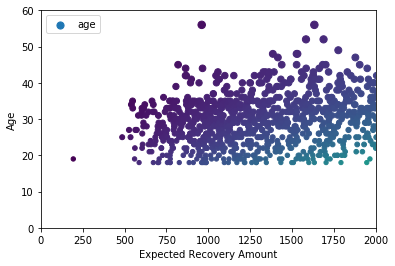

In [4]:
# Scatter plot of Age vs. Expected Recovery Amount
colors=df['expected_recovery_amount']/df['age']
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c=colors, s=df['age'])
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.legend(loc=2)
plt.show()

## Age Factor - Statistical View
- set the check range between 900 and 1100

In [6]:
# Compute average age just below and above the threshold
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Perform Kruskal-Wallis test 
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age,Level_1_age) 

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

## Sex Factor - Statistical View

In [7]:
# Number of customers in each category
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) & 
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'], 
                       df['sex'])
print(crosstab)
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
0.5377947810444592


# Strategy Feasibility Analysis
- confident that customers just above and just below the threshold are, on average, similar in their average age and the percentage that are male.
- focus on the key outcome of interest, the actual recovery amount

## Exploratory Graphical Analysis - Recovery Amount

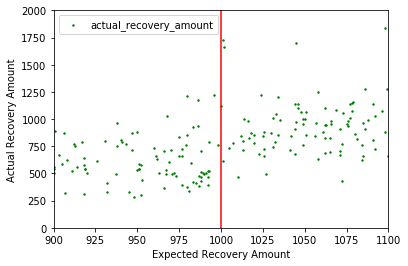

In [13]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount 
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.legend(loc=2)
plt.vlines(1000, 0, 2000, color='r')
plt.show()

## Statistical Analysis - Recovery Amount

In [9]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual, Level_1_actual))

# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual, Level_1_actual)

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)


KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

## Regression Modeling - No Threshold
- predicts the actual recovery amount (dependent variable) as a function of the expected recovery amount (independent variable)
- expect that there will be a strong positive relationship between these two variables

In [15]:
# Define X and y
X = era_900_1100["expected_recovery_amount"]
y = era_900_1100["actual_recovery_amount"]
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Wed, 15 Apr 2020   Prob (F-statistic):           1.56e-13
Time:                            11:36:44   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

C:\Users\Thinkpad\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Regression Modeling - Adding True Threshold
- create an indicator variable (either a 0 or a 1) that represents whether or not the expected recovery amount was greater than threshold
- if the higher recovery strategy helped recovery more money, then the regression coefficient of the true threshold will be greater than zero

In [16]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Wed, 15 Apr 2020   Prob (F-statistic):           1.83e-15
Time:                            11:41:57   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## Regression modeling - Adjusting the Window
- convince that the above result wasn't due to choosing an expected recovery amount window of 900 to 1100
- repeat analysis for the window from 950 to 1050 to see if we get similar results

In [21]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

# Define X and y 
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Wed, 15 Apr 2020   Prob (F-statistic):           1.12e-07
Time:                            12:20:11   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Conclusion
- the regression coefficient for the first true threshold model was statistically significant with an estimated impact of around 278
- this is much larger than the 50 per customer needed to run this higher recovery strategy
- whether we use a wide (900 to 1100) or narrower window (950 to 1050), the incremental recovery amount at the higher recovery strategy is much greater than the 50 per customer it costs for the higher recovery strategy
- so we conclude that the higher recovery strategy is worth the extra cost of 50 per customer